## 1. Create a Image Hash.

### Idea from https://github.com/mendesk/image-ndd-lsh

In [2]:
!python3 -m pip install imagehash Image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 KB 3.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 10.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 9.2 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 7.8 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 KB 7.0 MB/s eta 0:00:00
  Created wheel for Image: filename=image-1.5.33-py2.py3-none-any.whl size=19497 sha256=fd5c32d26a24438dea34d97ba13c8e1311432a0e213817f722c3a1f8f1a10a7f
  Stored in directory: /root/.cache/pip/wheels/70/0c/a4/7cfa53a5c6225c2db2bfec08e782b43d0f25fdae2e995b69be
Successfully built Image


In [3]:
import imagehash
from PIL import Image
import numpy as np

Article -> https://pypi.org/project/ImageHash/
dhash -> difference hash

In [6]:
def calculate_signature(image_file: str, hash_size: int) -> np.ndarray:
    pil_image = Image.open(image_file).convert("L").resize(
                        (hash_size+1, hash_size),
                        Image.LANCZOS)
    dhash = imagehash.dhash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()
    return signature

In [7]:
def calculate_signature_np(image_file: np.array, hash_size: int) -> np.ndarray:
    pil_image = Image.fromarray(image_file).convert("L").resize(
                        (hash_size+1, hash_size),
                        Image.LANCZOS)
    dhash = imagehash.dhash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()
    return signature

## 2. Create LSH algorithm

### 2.1 Get the dataset

In [11]:
#!apt-get install wget
#!wget -c https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

In [12]:
#!tar -xvzf cifar-10-python.tar.gz

In [13]:
#!rm -rf cifar-10-python.tar.gz
#!mv cifar-10-batches-py ../data

### 2.2 Read the files

In [14]:
import os
import _pickle as cPickle

In [15]:
PATH = "../data/cifar-10-batches-py/"

#### 2.2.1 Load Cifar-10

In [16]:
def load_batch():
    file = 'data_batch_1'

    f = open(PATH+file, 'rb')
    dict = cPickle.load(f, encoding='latin1')
    images = dict['data']
    #images = np.reshape(images, (10000, 3, 32, 32))
    labels = dict['labels']
    imagearray = np.array(images)   #   (10000, 3072)
    labelarray = np.array(labels)   #   (10000,)
    
    return imagearray, labelarray

In [17]:
def load_classes():
    file = 'batches.meta'
    
    f = open(PATH+file, 'rb')
    dict = cPickle.load(f)
    return dict['label_names']

def print_classes(label_names):
    for i in range(0, 10):
        print(str(i) + " : " + label_names[i] + "  ")

label_names = load_classes()
print_classes(label_names)

0 : airplane  
1 : automobile  
2 : bird  
3 : cat  
4 : deer  
5 : dog  
6 : frog  
7 : horse  
8 : ship  
9 : truck  


In [18]:
images, labels = load_batch()

In [19]:
labels.shape

(10000,)

In [20]:
image = np.reshape(images[0], (3, 32, 32))

In [21]:
image

array([[[ 59,  43,  50, ..., 158, 152, 148],
        [ 16,   0,  18, ..., 123, 119, 122],
        [ 25,  16,  49, ..., 118, 120, 109],
        ...,
        [208, 201, 198, ..., 160,  56,  53],
        [180, 173, 186, ..., 184,  97,  83],
        [177, 168, 179, ..., 216, 151, 123]],

       [[ 62,  46,  48, ..., 132, 125, 124],
        [ 20,   0,   8, ...,  88,  83,  87],
        [ 24,   7,  27, ...,  84,  84,  73],
        ...,
        [170, 153, 161, ..., 133,  31,  34],
        [139, 123, 144, ..., 148,  62,  53],
        [144, 129, 142, ..., 184, 118,  92]],

       [[ 63,  45,  43, ..., 108, 102, 103],
        [ 20,   0,   0, ...,  55,  50,  57],
        [ 21,   0,   8, ...,  50,  50,  42],
        ...,
        [ 96,  34,  26, ...,  70,   7,  20],
        [ 96,  42,  30, ...,  94,  34,  34],
        [116,  94,  87, ..., 140,  84,  72]]], dtype=uint8)

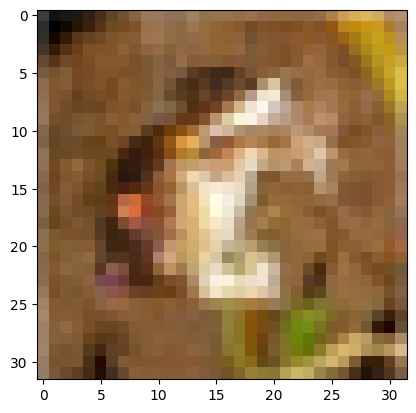

In [22]:
from matplotlib import pyplot as plt
plt.imshow(image.T, interpolation='nearest')
plt.show()

In [23]:
print(label_names[labels[0]])

frog


### 2.2.2 Algorithm

In [24]:
from typing import List, Dict, Tuple

class LSH:
    def __init__(self, size, hash_size):
        self.buckets = []
        self.bandsNumber = size
        self.rows = int(hash_size**2 / self.bandsNumber)
        self.hash_buckets_list: List[Dict[int, List[str]]] = [dict() for _ in range(self.bandsNumber)]
        self.signatures = dict()
        self.hash_size = hash_size

        for i in range(size):
            self.buckets.append({})
            
    def fill_buckets(self, signature, idx):
        for i in range(self.bandsNumber):
            signature_band = signature[i*self.rows:(i+1)*self.rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in self.hash_buckets_list[i]:
                self.hash_buckets_list[i][signature_band_bytes] = list()
            self.hash_buckets_list[i][signature_band_bytes].append(idx)
    
    def compute_hash(self, images):
        idx = 0;
        for image in images:
            signature = calculate_signature_np(image.T, self.hash_size)

            # Keep track of each image's signature
            self.signatures[idx] = np.packbits(signature)
            self.fill_buckets(signature, idx)
            idx+=1

    def compute_candidate(self):
        candidate_pairs = set()
        
        for hash_buckets in self.hash_buckets_list:
            for hash_bucket in hash_buckets.values():
                if len(hash_bucket) > 1:
                    hash_bucket = sorted(hash_bucket) # Why needed ?
                    for i in range(len(hash_bucket)):
                        for j in range(i+1, len(hash_bucket)):
                            candidate_pairs.add(
                                tuple([hash_bucket[i],hash_bucket[j]])
                            )
        return candidate_pairs

    def check_candidate(self, candidate_pairs, threshold=0.9):
        
        near_duplicates = list()
        for cpa, cpb in candidate_pairs:
            hd = sum(np.bitwise_xor(
                    np.unpackbits(signatures[cpa]), 
                    np.unpackbits(signatures[cpb])
            ))
            similarity = (self.hash_size**2 - hd) / self.hash_size**2
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates
            
    

In [25]:
lsh = LSH(15, 16)
lsh.compute_hash(images)
pairs = lsh.compute_candidate()
duplicates = lsh.check_candidate(pairs,0.8)

NameError: name 'signatures' is not defined

In [ ]:
len(duplicates)

In [ ]:
plt.imshow(images[5416].T, interpolation='nearest')
plt.show()

In [ ]:
labels[5416]

In [ ]:
plt.imshow(images[9786].T, interpolation='nearest')
plt.show()

In [ ]:
labels[9786]